#Imports and Settings

In [7]:
# STEP 0: Setup
!pip -q install wordcloud nltk

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from wordcloud import WordCloud

import re
import string

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Plot settings (nice looking defaults)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12

print("Setup complete.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Setup complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [8]:
# STEP 1: Load data + quick peek

file_path = "/content/fake reviews dataset.csv"  # change if your file name is different
df = pd.read_csv(file_path)

print("Shape (rows, cols):", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nFirst 5 rows:")
display(df.head())

print("\nRandom 5 samples:")
display(df.sample(5, random_state=42))

# Keep only relevant columns in a standard order (safe even if extra columns exist)
needed_cols = ["text_", "label", "rating", "category"]
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    print("\nWARNING: Missing expected columns:", missing)
else:
    df = df[needed_cols].copy()
    print("\nUsing columns:", needed_cols)


Shape (rows, cols): (40432, 4)

Columns: ['category', 'rating', 'label', 'text_']

First 5 rows:


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...



Random 5 samples:


,category,rating,label,text_
27957,Kindle_Store_5,3.0,CG,Eva is on her to find a way to escape her abus...
39755,Clothing_Shoes_and_Jewelry_5,5.0,CG,This is my second Glamorise and I love the loo...
24983,Kindle_Store_5,4.0,OR,I absolutely love this series. The Ravens are ...
13985,Movies_and_TV_5,5.0,CG,Probably best movie Rutger Howerton has made. ...
39275,Clothing_Shoes_and_Jewelry_5,5.0,OR,Unfortunately the black didn't work for a lot ...



Using columns: ['text_', 'label', 'rating', 'category']


Missing values per column:
text_       0
label       0
rating      0
category    0
dtype: int64

Duplicate rows: 12

Label counts:
label
CG    20216
OR    20216
Name: count, dtype: int64


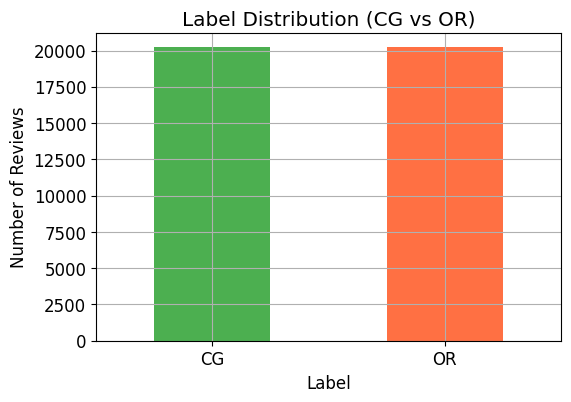


Label percentage distribution:
label
CG    50.0
OR    50.0
Name: count, dtype: float64


In [9]:
# STEP 2: Data quality checks + label distribution

print("Missing values per column:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# Label distribution
label_counts = df["label"].value_counts()
print("\nLabel counts:")
print(label_counts)

# Plot label distribution
plt.figure(figsize=(6,4))
label_counts.plot(kind="bar", color=["#4CAF50", "#FF7043"])
plt.title("Label Distribution (CG vs OR)")
plt.xlabel("Label")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

# Percentage distribution
label_pct = (label_counts / len(df)) * 100
print("\nLabel percentage distribution:")
print(label_pct.round(2))


In [10]:
# STEP 3: Text cleaning (without lemmatization/stemming yet)

# Remove duplicates first
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after removing duplicates:", df.shape)

# Keep original text
df["text_raw"] = df["text_"]

def clean_text_basic(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)        # remove URLs
    text = re.sub(r"<.*?>", "", text)                 # remove HTML tags
    text = re.sub(r"[^a-z\s]", " ", text)             # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()          # normalize spaces
    return text

df["text_clean"] = df["text_raw"].apply(clean_text_basic)

print("\nBefore vs After cleaning (5 samples):")
sample_df = df[["text_raw", "text_clean"]].sample(5, random_state=42)
display(sample_df)


Shape after removing duplicates: (40420, 4)

Before vs After cleaning (5 samples):


,text_raw,text_clean
5553,Well made hat. Soft and comfortable. Great q...,well made hat soft and comfortable great quali...
21921,and many different uses (I use this as a gate ...,and many different uses i use this as a gate q...
33592,Big hit with my 3 year old granddaughter. Her...,big hit with my year old granddaughter her dad...
20656,Did nothing. Still combing huge hay. The only ...,did nothing still combing huge hay the only pr...
28904,A wonderful read. I was sad when the story en...,a wonderful read i was sad when the story ende...


In [11]:
# STEP 4.1: Text length features

df["word_count"] = df["text_clean"].apply(lambda x: len(x.split()))
df["char_count"] = df["text_clean"].apply(len)

df[["label", "word_count", "char_count"]].describe()


,word_count,char_count
count,40420.000000,40420.000000
mean,68.595769,338.213310
std,70.755661,354.820022
min,0.000000,0.000000
25%,21.000000,103.000000
50%,39.000000,191.000000
75%,86.000000,423.000000
max,376.000000,2082.000000


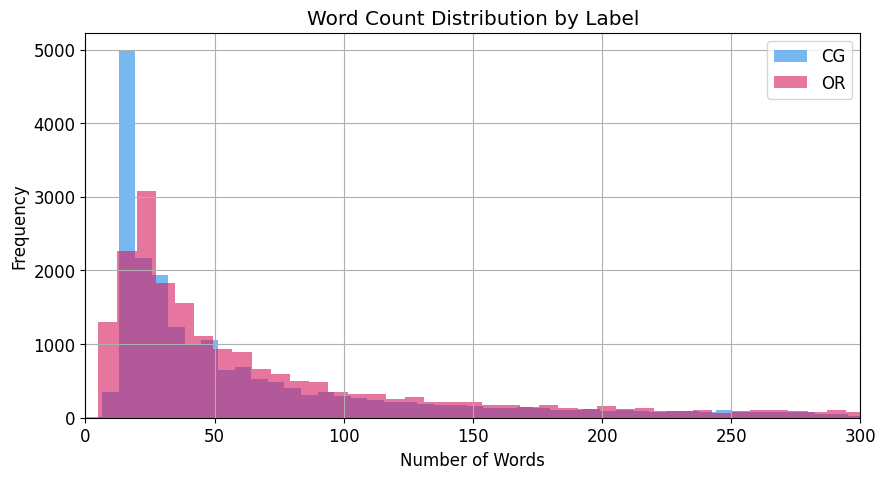

In [12]:
# STEP 4.2: Word count distribution by label

plt.figure(figsize=(10,5))

for label, color in zip(["CG", "OR"], ["#1E88E5", "#D81B60"]):
    subset = df[df["label"] == label]
    plt.hist(
        subset["word_count"],
        bins=50,
        alpha=0.6,
        label=label,
        color=color
    )

plt.title("Word Count Distribution by Label")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0, 300)  # limit extreme outliers for readability
plt.show()


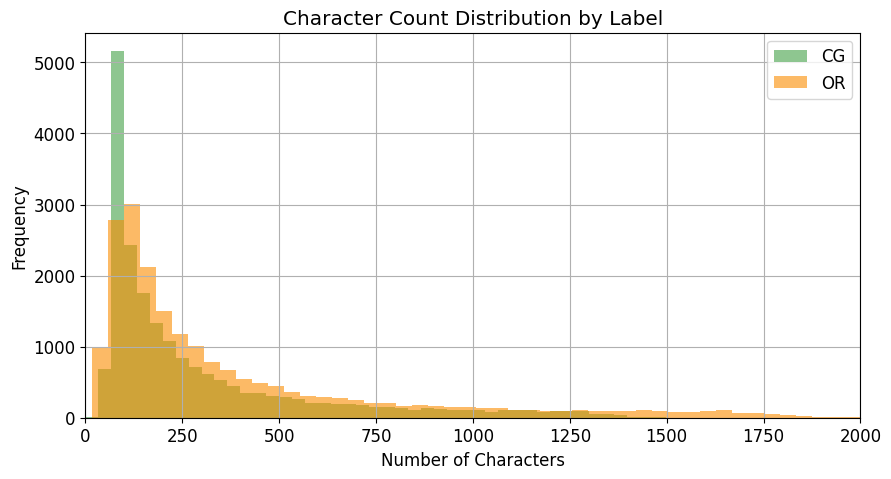

In [13]:
# STEP 4.3: Character count distribution by label

plt.figure(figsize=(10,5))

for label, color in zip(["CG", "OR"], ["#43A047", "#FB8C00"]):
    subset = df[df["label"] == label]
    plt.hist(
        subset["char_count"],
        bins=50,
        alpha=0.6,
        label=label,
        color=color
    )

plt.title("Character Count Distribution by Label")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.legend()
plt.xlim(0, 2000)
plt.show()


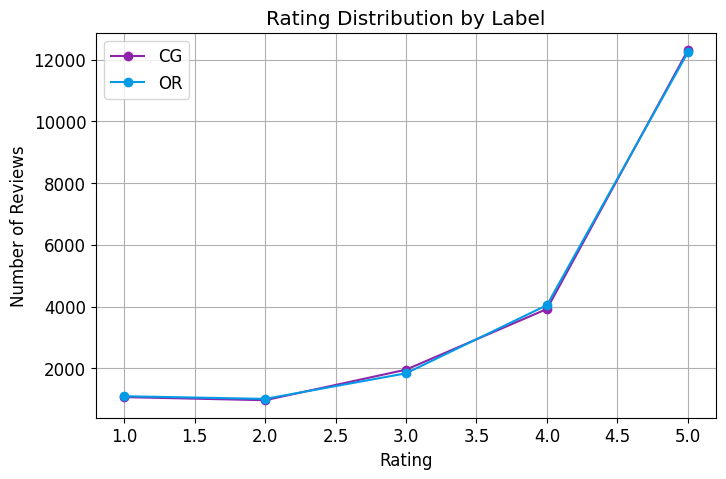

In [14]:
# STEP 4.4: Rating distribution by label

rating_counts = (
    df.groupby(["label", "rating"])
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(8,5))

for label, color in zip(["CG", "OR"], ["#8E24AA", "#039BE5"]):
    subset = rating_counts[rating_counts["label"] == label]
    plt.plot(
        subset["rating"],
        subset["count"],
        marker="o",
        label=label,
        color=color
    )

plt.title("Rating Distribution by Label")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.legend()
plt.grid(True)
plt.show()


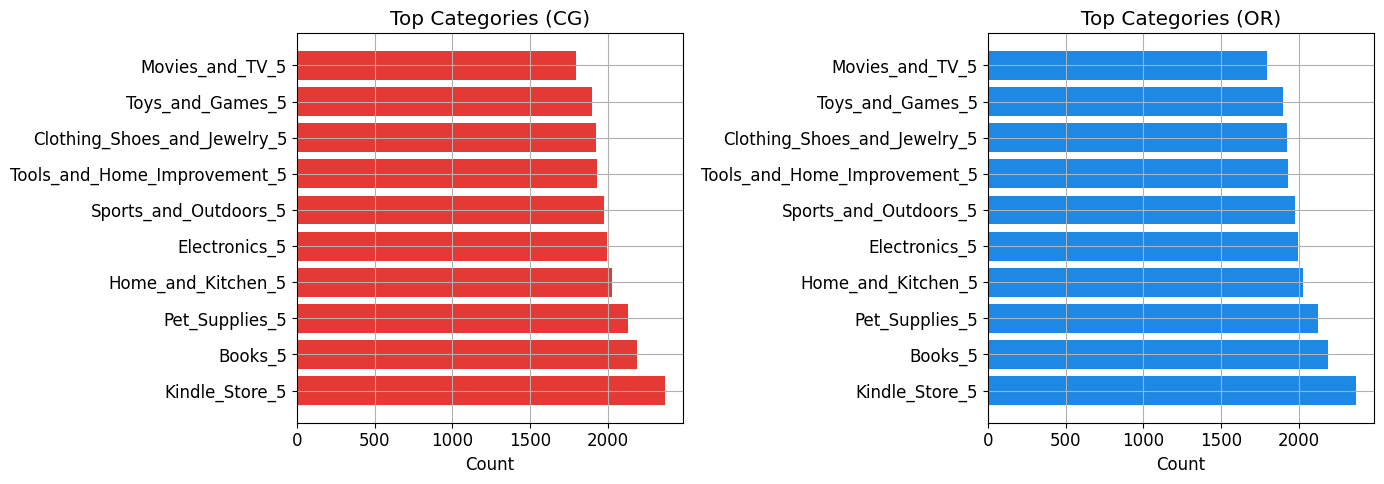

In [15]:
# STEP 4.5: Top categories by label

top_categories = (
    df.groupby(["label", "category"])
      .size()
      .reset_index(name="count")
)

# Get top 10 categories per label
top_cg = top_categories[top_categories["label"] == "CG"].nlargest(10, "count")
top_or = top_categories[top_categories["label"] == "OR"].nlargest(10, "count")

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.barh(top_cg["category"], top_cg["count"], color="#E53935")
plt.title("Top Categories (CG)")
plt.xlabel("Count")

plt.subplot(1,2,2)
plt.barh(top_or["category"], top_or["count"], color="#1E88E5")
plt.title("Top Categories (OR)")
plt.xlabel("Count")

plt.tight_layout()
plt.show()


In [16]:
# STEP 5.1: Combine text by label

cg_text = " ".join(df[df["label"] == "CG"]["text_clean"])
or_text = " ".join(df[df["label"] == "OR"]["text_clean"])

print("CG text length:", len(cg_text))
print("OR text length:", len(or_text))


CG text length: 5980498
OR text length: 7730502


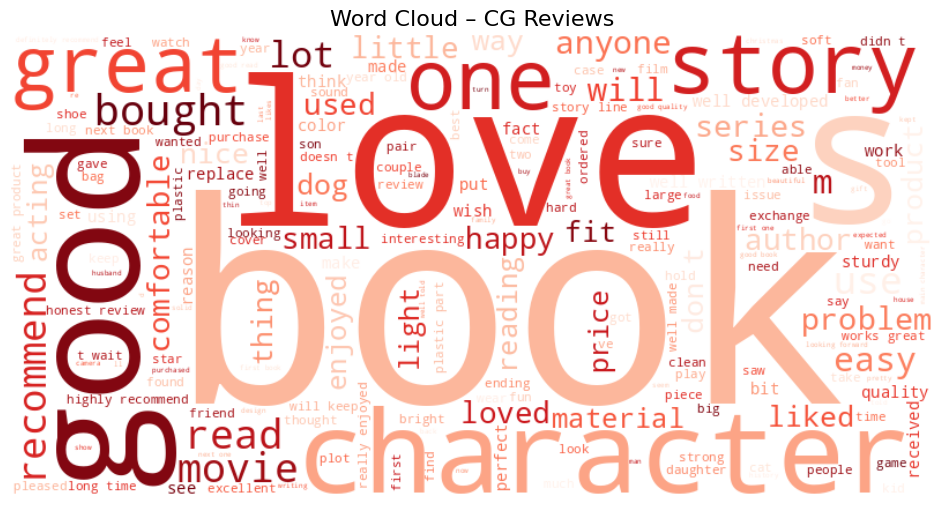

In [17]:
# STEP 5.2: Word cloud for CG reviews

wc_cg = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Reds",
    max_words=200
).generate(cg_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_cg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – CG Reviews", fontsize=16)
plt.show()


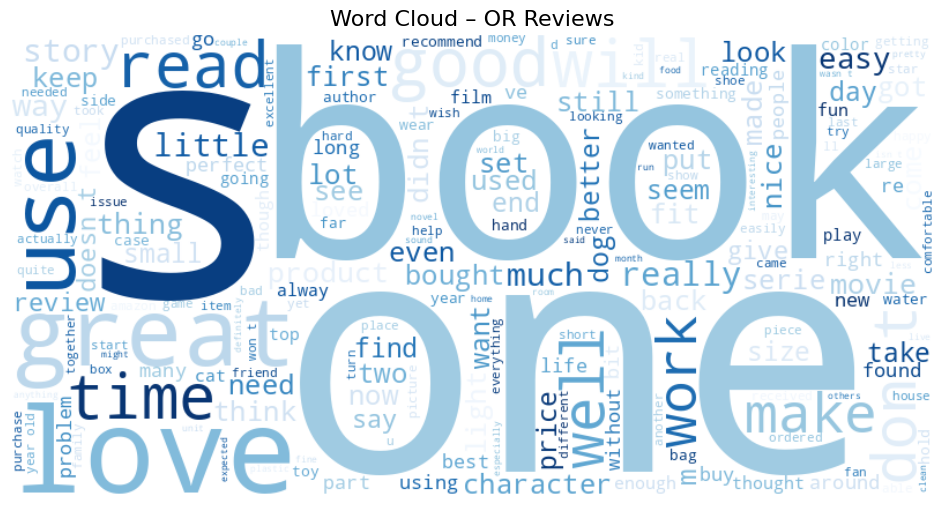

In [18]:
# STEP 5.3: Word cloud for OR reviews

wc_or = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Blues",
    max_words=200
).generate(or_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_or, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – OR Reviews", fontsize=16)
plt.show()


In [19]:
# STEP 6.1: NLP tools setup

stop_words = set(stopwords.words("english"))

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

print("Stopwords count:", len(stop_words))
print("Example stopwords:", list(stop_words)[:10])


Stopwords count: 198
Example stopwords: ['by', "should've", 'then', 'over', 'their', 're', "i've", "haven't", "it's", 'it']


In [21]:
# FIX: download missing tokenizer resource
import nltk
nltk.download("punkt_tab")
print("punkt_tab downloaded successfully")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


punkt_tab downloaded successfully


In [22]:
# STEP 6.2: Tokenization + stopword removal

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

df["tokens"] = df["text_clean"].apply(tokenize_and_remove_stopwords)

df[["text_clean", "tokens"]].sample(5, random_state=42)


,text_clean,tokens
5553,well made hat soft and comfortable great quali...,"[well, made, hat, soft, comfortable, great, qu..."
21921,and many different uses i use this as a gate q...,"[many, different, uses, use, gate, quite, ofte..."
33592,big hit with my year old granddaughter her dad...,"[big, hit, year, old, granddaughter, dad, big,..."
20656,did nothing still combing huge hay the only pr...,"[nothing, still, combing, huge, hay, problem, ..."
28904,a wonderful read i was sad when the story ende...,"[wonderful, read, sad, story, ended, nora, rob..."


In [23]:
# STEP 6.3: Lemmatization

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df["tokens_lemma"] = df["tokens"].apply(lemmatize_tokens)

df[["tokens", "tokens_lemma"]].sample(5, random_state=42)


,tokens,tokens_lemma
5553,"[well, made, hat, soft, comfortable, great, qu...","[well, made, hat, soft, comfortable, great, qu..."
21921,"[many, different, uses, use, gate, quite, ofte...","[many, different, us, use, gate, quite, often,..."
33592,"[big, hit, year, old, granddaughter, dad, big,...","[big, hit, year, old, granddaughter, dad, big,..."
20656,"[nothing, still, combing, huge, hay, problem, ...","[nothing, still, combing, huge, hay, problem, ..."
28904,"[wonderful, read, sad, story, ended, nora, rob...","[wonderful, read, sad, story, ended, nora, rob..."


In [24]:
# STEP 6.4: Stemming

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

df["tokens_stem"] = df["tokens"].apply(stem_tokens)

df[["tokens", "tokens_stem"]].sample(5, random_state=42)


,tokens,tokens_stem
5553,"[well, made, hat, soft, comfortable, great, qu...","[well, made, hat, soft, comfort, great, qualit..."
21921,"[many, different, uses, use, gate, quite, ofte...","[mani, differ, use, use, gate, quit, often, se..."
33592,"[big, hit, year, old, granddaughter, dad, big,...","[big, hit, year, old, granddaught, dad, big, f..."
20656,"[nothing, still, combing, huge, hay, problem, ...","[noth, still, comb, huge, hay, problem, kind, ..."
28904,"[wonderful, read, sad, story, ended, nora, rob...","[wonder, read, sad, stori, end, nora, robert, ..."


In [25]:
# STEP 6.5: Rebuild processed text strings

df["text_lemma"] = df["tokens_lemma"].apply(lambda x: " ".join(x))
df["text_stem"] = df["tokens_stem"].apply(lambda x: " ".join(x))

df[["text_clean", "text_lemma", "text_stem"]].sample(5, random_state=42)


,text_clean,text_lemma,text_stem
5553,well made hat soft and comfortable great quali...,well made hat soft comfortable great quality a...,well made hat soft comfort great qualiti also ...
21921,and many different uses i use this as a gate q...,many different us use gate quite often separat...,mani differ use use gate quit often separ seni...
33592,big hit with my year old granddaughter her dad...,big hit year old granddaughter dad big fan game,big hit year old granddaught dad big fan game
20656,did nothing still combing huge hay the only pr...,nothing still combing huge hay problem kind ha...,noth still comb huge hay problem kind hard find
28904,a wonderful read i was sad when the story ende...,wonderful read sad story ended nora robert nev...,wonder read sad stori end nora robert never fa...


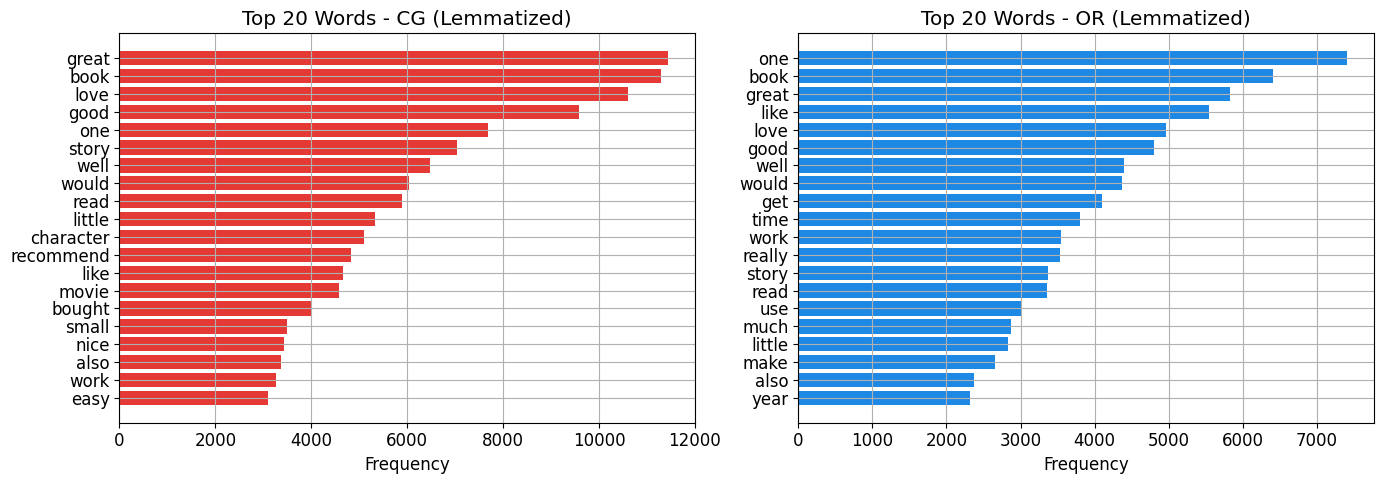

In [26]:
# STEP 7.1: Top words by label (after lemmatization)

from collections import Counter

def get_top_words(df_subset, col, top_n=20):
    all_tokens = " ".join(df_subset[col]).split()
    return Counter(all_tokens).most_common(top_n)

top_cg_words = get_top_words(df[df["label"]=="CG"], "text_lemma", 20)
top_or_words = get_top_words(df[df["label"]=="OR"], "text_lemma", 20)

cg_words, cg_counts = zip(*top_cg_words)
or_words, or_counts = zip(*top_or_words)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.barh(cg_words[::-1], cg_counts[::-1], color="#E53935")
plt.title("Top 20 Words - CG (Lemmatized)")
plt.xlabel("Frequency")

plt.subplot(1,2,2)
plt.barh(or_words[::-1], or_counts[::-1], color="#1E88E5")
plt.title("Top 20 Words - OR (Lemmatized)")
plt.xlabel("Frequency")

plt.tight_layout()
plt.show()


Vocabulary Size
text_clean: 38688
text_lemma: 33704
text_stem : 25642


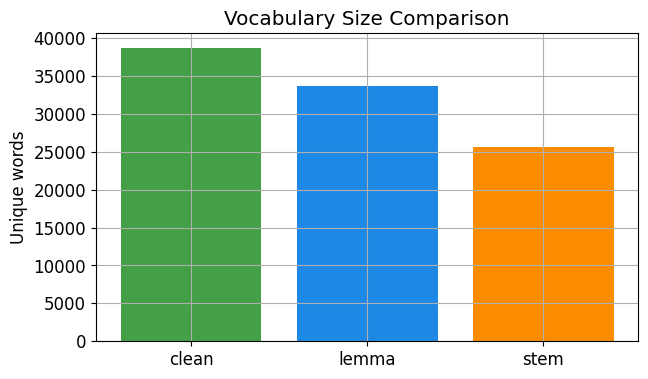

In [27]:
# STEP 7.2: Vocabulary size comparison

def vocab_size(series):
    words = " ".join(series).split()
    return len(set(words))

v_clean = vocab_size(df["text_clean"])
v_lemma = vocab_size(df["text_lemma"])
v_stem  = vocab_size(df["text_stem"])

print("Vocabulary Size")
print("text_clean:", v_clean)
print("text_lemma:", v_lemma)
print("text_stem :", v_stem)

plt.figure(figsize=(7,4))
plt.bar(["clean", "lemma", "stem"], [v_clean, v_lemma, v_stem], color=["#43A047","#1E88E5","#FB8C00"])
plt.title("Vocabulary Size Comparison")
plt.ylabel("Unique words")
plt.show()


In [28]:
# STEP 7.3: TF-IDF feature inspection

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    max_features=30000,
    min_df=2
)

X_tfidf = tfidf.fit_transform(df["text_lemma"])
print("TF-IDF matrix shape:", X_tfidf.shape)

feature_names = tfidf.get_feature_names_out()
print("Number of features:", len(feature_names))
print("Sample features:", feature_names[:30])


TF-IDF matrix shape: (40420, 30000)
Number of features: 30000
Sample features: ['aaa' 'aaa battery' 'aaron' 'ab' 'abandoned' 'abbey' 'abby' 'abc'
 'abducted' 'abigail' 'ability' 'ability hold' 'ability make' 'able'
 'able access' 'able adjust' 'able amazon' 'able assemble' 'able away'
 'able care' 'able carry' 'able character' 'able chew' 'able connect'
 'able control' 'able cut' 'able eat' 'able enjoy' 'able feel'
 'able fight']


In [29]:
# STEP 8.1: Train-test split

from sklearn.model_selection import train_test_split

X_clean = df["text_clean"]
X_lemma = df["text_lemma"]
y = df["label"]

Xc_train, Xc_test, y_train, y_test = train_test_split(
    X_clean, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Xl_train, Xl_test, _, _ = train_test_split(
    X_lemma, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", Xc_train.shape[0])
print("Test size :", Xc_test.shape[0])


Train size: 32336
Test size : 8084


In [30]:
# STEP 8.2: Logistic Regression on clean text

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe_clean = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=30000,
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=3000))
])

pipe_clean.fit(Xc_train, y_train)

y_pred_clean = pipe_clean.predict(Xc_test)

print("Logistic Regression (Clean Text)")
print(classification_report(y_test, y_pred_clean))


Logistic Regression (Clean Text)
              precision    recall  f1-score   support

          CG       0.90      0.88      0.89      4041
          OR       0.88      0.90      0.89      4043

    accuracy                           0.89      8084
   macro avg       0.89      0.89      0.89      8084
weighted avg       0.89      0.89      0.89      8084



In [31]:
# STEP 8.3: Logistic Regression on lemmatized text

pipe_lemma = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=30000,
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=3000))
])

pipe_lemma.fit(Xl_train, y_train)

y_pred_lemma = pipe_lemma.predict(Xl_test)

print("Logistic Regression (Lemmatized Text)")
print(classification_report(y_test, y_pred_lemma))


Logistic Regression (Lemmatized Text)
              precision    recall  f1-score   support

          CG       0.88      0.87      0.88      4041
          OR       0.87      0.89      0.88      4043

    accuracy                           0.88      8084
   macro avg       0.88      0.88      0.88      8084
weighted avg       0.88      0.88      0.88      8084



In [32]:
from sklearn.metrics import accuracy_score

results = pd.DataFrame({
    "Text Version": ["Clean", "Lemmatized"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_clean),
        accuracy_score(y_test, y_pred_lemma)
    ]
})

results


,Text Version,Accuracy
0,Clean,0.887061
1,Lemmatized,0.878525


In [33]:
# STEP 9.1: Linear SVM on clean text

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svm_clean = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1,2),
        max_features=30000,
        min_df=2
    )),
    ("clf", LinearSVC())
])

svm_clean.fit(Xc_train, y_train)

y_pred_svm = svm_clean.predict(Xc_test)

print("Linear SVM (Clean Text)")
print(classification_report(y_test, y_pred_svm))


Linear SVM (Clean Text)
              precision    recall  f1-score   support

          CG       0.90      0.90      0.90      4041
          OR       0.90      0.90      0.90      4043

    accuracy                           0.90      8084
   macro avg       0.90      0.90      0.90      8084
weighted avg       0.90      0.90      0.90      8084



In [34]:
from sklearn.metrics import accuracy_score

comparison = pd.DataFrame({
    "Model": ["Logistic Regression (Clean)", "Linear SVM (Clean)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_clean),
        accuracy_score(y_test, y_pred_svm)
    ]
})

comparison


,Model,Accuracy
0,Logistic Regression (Clean),0.887061
1,Linear SVM (Clean),0.900049


In [35]:
# STEP 10.1: Get decision scores from SVM

decision_scores = svm_clean.decision_function(Xc_test)

results = pd.DataFrame({
    "text": Xc_test.values,
    "actual": y_test.values,
    "predicted": y_pred_svm,
    "confidence": np.abs(decision_scores)
})

print("Total test samples:", results.shape[0])
results.head()


Total test samples: 8084


,text,actual,predicted,confidence
0,this is good quality strapping i used it for s...,OR,OR,0.174230
1,supposed to come with extra hardware the only ...,CG,CG,0.485912
2,worked great for several ceiling fans that req...,OR,OR,1.459508
3,these small headphones are very comfortable an...,CG,CG,1.174392
4,searched and read reviews for this item and th...,CG,CG,0.167160


In [36]:
# STEP 10.2: Most confident wrong predictions

wrong_preds = results[results["actual"] != results["predicted"]]
wrong_preds_sorted = wrong_preds.sort_values(
    by="confidence", ascending=False
)

wrong_preds_sorted.head(10)


,text,actual,predicted,confidence
4910,these are very nice no bulbs to replace and ar...,OR,CG,1.754093
6848,didn t quite sit flat on the table but it work...,CG,OR,1.581344
7757,your average masking tape nothing else will wo...,CG,OR,1.541072
8071,this net is very versatile it can be used in a...,CG,OR,1.461585
5927,i don t usually like romance but i like it i l...,CG,OR,1.452679
1871,you are killin me sylvia you re killing me i w...,CG,OR,1.407891
3585,as always rebus never fails to leave you with ...,CG,OR,1.379919
3487,i really like this but was a little large the ...,OR,CG,1.259535
6804,tea y enjoyed this novel and look forward to t...,CG,OR,1.233752
5600,i can tell the little ticks have been removed ...,CG,OR,1.208050


In [37]:
# STEP 10.3: Inspect confusing examples

for i, row in wrong_preds_sorted.head(5).iterrows():
    print("Actual:", row["actual"])
    print("Predicted:", row["predicted"])
    print("Confidence:", round(row["confidence"], 3))
    print("Text:", row["text"][:500])
    print("-" * 80)


Actual: OR
Predicted: CG
Confidence: 1.754
Text: these are very nice no bulbs to replace and are bright and work well look great too
--------------------------------------------------------------------------------
Actual: CG
Predicted: OR
Confidence: 1.581
Text: didn t quite sit flat on the table but it worked perfectly i just got this one
--------------------------------------------------------------------------------
Actual: CG
Predicted: OR
Confidence: 1.541
Text: your average masking tape nothing else will work not worth it
--------------------------------------------------------------------------------
Actual: CG
Predicted: OR
Confidence: 1.462
Text: this net is very versatile it can be used in a variety of ways including as a stand up stand up or a stand up stand
--------------------------------------------------------------------------------
Actual: CG
Predicted: OR
Confidence: 1.453
Text: i don t usually like romance but i like it i like the new storyteller
--------------------

In [38]:
# STEP 11.1: Extract SVM feature weights

svm_clf = svm_clean.named_steps["clf"]
tfidf_vec = svm_clean.named_steps["tfidf"]

feature_names = np.array(tfidf_vec.get_feature_names_out())
coefficients = svm_clf.coef_[0]

print("Number of features:", len(feature_names))


Number of features: 30000


In [39]:
print("Class order:", svm_clf.classes_)


Class order: ['CG' 'OR']


In [40]:
# STEP 11.3: Top weighted words per class

top_n = 20

top_or_idx = np.argsort(coefficients)[-top_n:][::-1]
top_cg_idx = np.argsort(coefficients)[:top_n]

top_or_words = feature_names[top_or_idx]
top_or_weights = coefficients[top_or_idx]

top_cg_words = feature_names[top_cg_idx]
top_cg_weights = coefficients[top_cg_idx]

print("Top words pushing toward OR:\n")
for w, c in zip(top_or_words, top_or_weights):
    print(f"{w:20s} {c:.3f}")

print("\nTop words pushing toward CG:\n")
for w, c in zip(top_cg_words, top_cg_weights):
    print(f"{w:20s} {c:.3f}")


Top words pushing toward OR:

plus                 1.857
instead              1.833
actually             1.829
end                  1.735
maybe                1.726
ago                  1.710
far                  1.665
away                 1.663
changes              1.657
coming               1.637
sell                 1.632
normal               1.630
star                 1.621
curious              1.596
today                1.591
standing             1.584
compared             1.583
ease                 1.583
potatoes             1.581
believe              1.578

Top words pushing toward CG:

reason gave          -3.471
admit                -3.044
problem kind         -2.850
downside             -2.789
problem really       -2.736
reason               -2.678
just starting        -2.675
little smaller       -2.620
bought friend        -2.584
definitely buying    -2.531
did need             -2.450
couple               -2.398
replace              -2.389
story told           -2.350
plastic

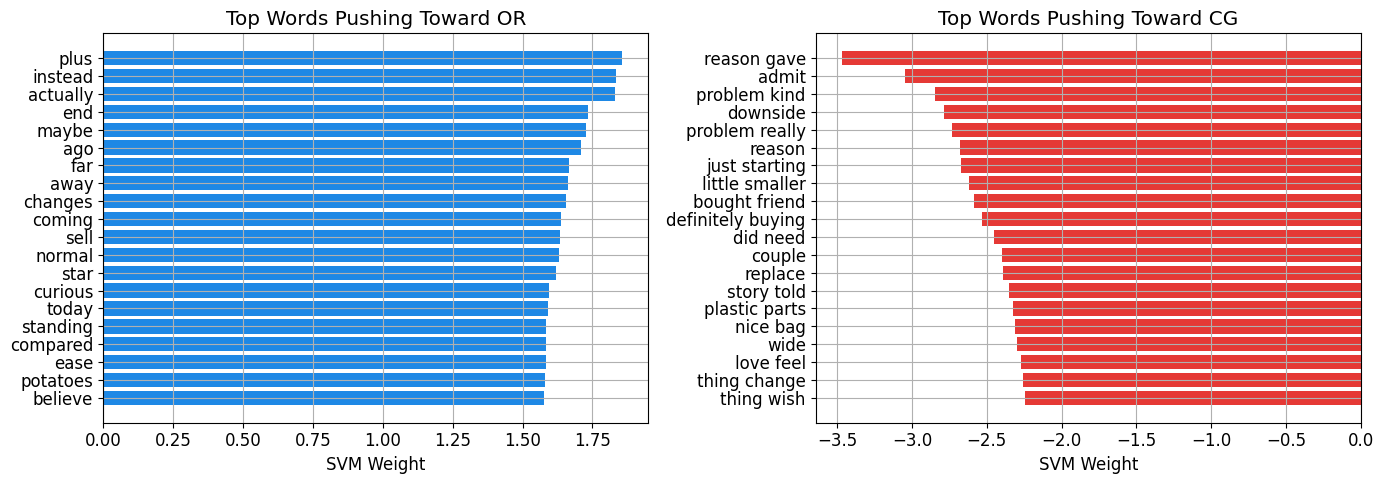

In [41]:
# STEP 11.4: Visualization of influential words

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.barh(top_or_words[::-1], top_or_weights[::-1], color="#1E88E5")
plt.title("Top Words Pushing Toward OR")
plt.xlabel("SVM Weight")

plt.subplot(1,2,2)
plt.barh(top_cg_words[::-1], top_cg_weights[::-1], color="#E53935")
plt.title("Top Words Pushing Toward CG")
plt.xlabel("SVM Weight")

plt.tight_layout()
plt.show()


In [42]:
# STEP 12.1: Save trained model

import joblib

model_path = "/content/fake_review_svm_model.joblib"
joblib.dump(svm_clean, model_path)

print("Model saved to:", model_path)


Model saved to: /content/fake_review_svm_model.joblib


In [43]:
# STEP 12.2: Inference function

def predict_review(text, model=svm_clean):
    text = clean_text_basic(text)
    decision = model.decision_function([text])[0]
    label = model.predict([text])[0]
    confidence = abs(decision)
    return {
        "prediction": label,
        "confidence": round(confidence, 3)
    }


In [44]:
# STEP 12.3: Test predictions

samples = [
    "Absolutely loved this product. Works perfectly and exceeded my expectations.",
    "Bought this for my mother after comparing several options. It has been working well for over 6 months."
]

for s in samples:
    print(s)
    print(predict_review(s))
    print("-" * 60)


Absolutely loved this product. Works perfectly and exceeded my expectations.
{'prediction': 'OR', 'confidence': np.float64(1.038)}
------------------------------------------------------------
Bought this for my mother after comparing several options. It has been working well for over 6 months.
{'prediction': 'OR', 'confidence': np.float64(0.388)}
------------------------------------------------------------
